# **Telecom Churn Analysis using MCMC Methods**
The dataset is collected from Kaggle. It is to anlayse which customers are likely to churn.
Here, I will try to explore MCMC methods by using this dataset and the runtime of MCMC methods is very delayed therefore, I would choose only minimum important features as predictors.

Further, to implement different distributions, below is a compact explanation which could help me to choose a reference distribution.
distribution:

- **Uniform Distribution:** The uniform distribution defines equal probability over a given range for a continuous distribution. For this reason, it is important as a reference distribution(prior decision).

- **Normal Distribution:** also known as the Gaussian distribution, it is symmetric, unimodal, and asymptotic, and the mean, median, and mode are all equal. A normal distribution is perfectly symmetrical around its center. That is, the right side of the center is a mirror image of the left side.

- **Half-normal Distribution:** It is a Normal distribution truncated to only have nonzero probability density for values greater than or equal to the location of the peak.

- **Skew-normal Distribution:** If one tail is longer than another, the distribution is skewed. It can be either left or right skewed and the mean will be shifted to either side of the median.

- **Dirichlet Distribution:** The Dirichlet distribution is the conjugate prior distribution of the categorical distribution (a generic discrete probability distribution with a given number of possible outcomes) and multinomial distribution (the distribution over observed counts of each possible category in a set of categorically distributed observations). This means that if a data point has either a categorical or multinomial distribution.

- **Beta Distribution:** Applied to model the behavior of random variables limited to intervals of finite length in a wide variety of disciplines. It is the conjugate prior probability distribution for the Bernoulli, binomial, negative binomial and geometric distributions. Also, it is a suitable model for the random behavior of percentages and proportions.

- **Categorical Distribution:** It is a discrete probability distribution that describes the possible results of a random variable that can take on one of K possible categories, with the probability of each category separately specified.

- **GLM Distribution:** Some common GLM families are Gaussian, Binomial, Poisson, Gamma and Inverse-Gamma. The GLM generalizes linear regression by allowing the linear model to be related to the response variable via a link function and by allowing the magnitude of the variance of each measurement to be a function of its predicted value.

- **Binomial Distribution:** The binomial is a type of distribution that has two possible outcomes for e.g., success or failure. It summarizes the likelihood that a value will take one of two independent values under a given set of parameters or assumptions. Also, there is only one outcome for each trial, with same probability of success, and independent of one another.

- **Negative Binomial Distribution:** has very similar characteristics to the Poisson distribution except that it has two parameters (𝜇 and 𝛼) which enables it to vary its variance independently of its mean.

- **Poisson Distribution:** is generally used to describe the probability of a given number of events occurring on a fixed time/space interval.

Below is the explanantion of MCMC Sampling methods that are commonly used using **PyMC** library:

- **NUTS:** NUTS uses a recursive algorithm to build a set of likely candidate points that spans a wide swath of the target distribution, stopping automatically when it starts to double back and retrace its steps.

- **Metropolis Hastings:** An algorithm is a MCMC method for obtaining a sequence of random samples by random walk from a probability distribution from which direct sampling is difficult.

- **Hamiltonian MonteCarlo:** obtains a sequence of random samples which converge to being distributed according to a target probability distribution. It reduces the correlation between successive sampled states by proposing moves to distant states which maintain a high probability of acceptance due to the approximate energy conserving properties.

- **CategoricalGibbsMetropolis:** The Gibbs Sampling is a Monte Carlo Markov Chain method that iteratively draws an instance from the distribution of each variable, conditional on the current values of the other variables in order to estimate complex joint distributions. It always accept the proposal. A Metropolis-within-Gibbs step method optimized for categorical variables. Step method supports two types of proposals: A uniform proposal and a proportional proposal.

Now let's get started...

## **Import Libraries**

In [ ]:
# importing libraries
import numpy as np
import scipy
from scipy import stats
import matplotlib as mpl   
import matplotlib.pyplot as plt
import os
import csv
import arviz as az
import seaborn as sns
sns_c = sns.color_palette(palette='deep')

import pandas as pd
from sklearn import preprocessing
import theano as T

import math 
import itertools
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

import pymc3 as pm
import pymc3.distributions.continuous as pmc
import pymc3.distributions.discrete as pmd
import pymc3.math as pmm

from sklearn.model_selection import train_test_split


import json
# s = json.load(open('../style/bmh_matplotlibrc.json'))
# matplotlib.rcParams.update(s)
# matplotlib.rcParams['figure.figsize'] = (10, 3)
# matplotlib.rcParams['font.size'] = 14
# matplotlib.rcParams['ytick.major.size'] = 20


import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

## **Fetch Data**

In [ ]:
filename = "https://raw.githubusercontent.com/Rumsha001/ML2/main/dataset/telecom_dataset.csv"
# read data from csv file
data = pd.read_csv(filename)
df = pd.DataFrame(data)
df

,CustomerID,Churn,MonthlyRevenue,MonthlyMinutes,TotalRecurringCharge,DirectorAssistedCalls,OverageMinutes,RoamingCalls,PercChangeMinutes,PercChangeRevenues,DroppedCalls,BlockedCalls,UnansweredCalls,CustomerCareCalls,ThreewayCalls,ReceivedCalls,OutboundCalls,InboundCalls,PeakCallsInOut,OffPeakCallsInOut,DroppedBlockedCalls,CallForwardingCalls,CallWaitingCalls,MonthsInService,UniqueSubs,ActiveSubs,ServiceArea,Handsets,HandsetModels,CurrentEquipmentDays,AgeHH1,AgeHH2,ChildrenInHH,HandsetRefurbished,HandsetWebCapable,TruckOwner,RVOwner,Homeownership,BuysViaMailOrder,RespondsToMailOffers,OptOutMailings,NonUSTravel,OwnsComputer,HasCreditCard,RetentionCalls,RetentionOffersAccepted,NewCellphoneUser,NotNewCellphoneUser,ReferralsMadeBySubscriber,IncomeGroup,OwnsMotorcycle,AdjustmentsToCreditRating,HandsetPrice,MadeCallToRetentionTeam,CreditRating,PrizmCode,Occupation,MaritalStatus
0,3000002,Yes,24.00,219.0,22.0,0.25,0.0,0.0,-157.0,-19.0,0.7,0.7,6.3,0.0,0.0,97.2,0.0,0.0,58.0,24.0,1.3,0.0,0.3,61,2,1,SEAPOR503,2.0,2.0,361.0,62.0,0.0,No,No,Yes,No,No,Known,Yes,Yes,No,No,Yes,Yes,1,0,No,No,0,4,No,0,30,Yes,1-Highest,Suburban,Professional,No
1,3000010,Yes,16.99,10.0,17.0,0.00,0.0,0.0,-4.0,0.0,0.3,0.0,2.7,0.0,0.0,0.0,0.0,0.0,5.0,1.0,0.3,0.0,0.0,58,1,1,PITHOM412,2.0,1.0,1504.0,40.0,42.0,Yes,No,No,No,No,Known,Yes,Yes,No,No,Yes,Yes,0,0,Yes,No,0,5,No,0,30,No,4-Medium,Suburban,Professional,Yes
2,3000014,No,38.00,8.0,38.0,0.00,0.0,0.0,-2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.4,0.3,0.0,1.3,3.7,0.0,0.0,0.0,60,1,1,MILMIL414,1.0,1.0,1812.0,26.0,26.0,Yes,No,No,No,No,Unknown,No,No,No,No,No,Yes,0,0,Yes,No,0,6,No,0,Unknown,No,3-Good,Town,Crafts,Yes
3,3000022,No,82.28,1312.0,75.0,1.24,0.0,0.0,157.0,8.1,52.0,7.7,76.0,4.3,1.3,200.3,370.3,147.0,555.7,303.7,59.7,0.0,22.7,59,2,2,PITHOM412,9.0,4.0,458.0,30.0,0.0,No,No,Yes,No,No,Known,Yes,Yes,No,No,No,Yes,0,0,Yes,No,0,6,No,0,10,No,4-Medium,Other,Other,No
4,3000026,Yes,17.14,0.0,17.0,0.00,0.0,0.0,0.0,-0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,53,2,2,OKCTUL918,4.0,3.0,852.0,46.0,54.0,No,No,No,No,No,Known,Yes,Yes,No,No,Yes,Yes,0,0,No,Yes,0,9,No,1,10,No,1-Highest,Other,Professional,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51042,3399958,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.3,2.7,48.3,0.0,0.0,58.9,17.0,1.3,160.3,33.3,12.0,0.0,0.3,29,1,1,LAXSFN818,2.0,2.0,526.0,68.0,64.0,No,Yes,Yes,No,No,Known,Yes,Yes,No,No,No,Yes,0,0,No,No,0,6,No,0,60,No,1-Highest,Suburban,Other,Yes
51043,3399974,No,95.17,1745.0,85.0,0.99,45.0,4.7,122.0,15.9,16.7,0.7,41.3,0.0,0.0,681.5,89.7,33.3,318.7,248.3,17.3,0.0,14.3,29,1,1,LAXCDG310,2.0,2.0,464.0,48.0,48.0,Yes,No,Yes,No,No,Known,Yes,Yes,No,No,Yes,Yes,0,0,No,No,0,9,No,1,60,No,3-Good,Other,Other,No
51044,3399978,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,71.7,4.3,287.0,1.3,13.7,1225.3,430.3,87.7,1359.0,910.3,76.0,0.0,6.7,25,1,1,LAXCDG310,3.0,2.0,378.0,36.0,0.0,No,No,Yes,No,No,Known,No,No,No,No,No,Yes,0,0,No,No,0,7,No,1,80,No,5-Low,Other,Clerical,No
51045,3399990,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,31,1,1,NEVPOW619,2.0,2.0,433.0,32.0,0.0,Yes,No,Yes,No,No,Unknown,No,No,No,No,No,No,0,0,No,No,0,9,No,0,30,No,5-Low,Other,Other,No


## **Helper Functions**

In [ ]:
# Loading dataset creditcard
def read_csv(filename):
  with open(filename, 'r') as f:
    reader=csv.reader(f, delimiter=',') 
    labels=next(reader)

    raw_data=[]
    for row in reader:
        raw_data.append(row)

  data = np.array(raw_data)
  data = data.astype(np.float)
  return data

def logistic(l):
  # x = np.random.randn(100)
  # x_shared = T.shared(x)
  # return x_shared*l
  return 1 / (1 + T.tensor.exp(-l))

# def logistic(x=x, beta=beta):
#     return 1.0 / (1. + np.exp(beta * x))

def view_distribution(data):
  az.plot_kde(data, rug=True)
  return plt.yticks([0], alpha=0)

def get_scaled_df(df,cols):
  rob_sc = preprocessing.RobustScaler()
# df2= df.copy(deep=True)
  scaled_t = rob_sc.fit_transform(df.reshape(-1,1))
  # scaled_amount = rob_sc.fit_transform(df[cols[1]].values.reshape(-1,1))
  # # Amount and Time are Scaled so we are removing unsacled features!
  # df.drop(cols, axis=1, inplace=True)
  # df.insert(cols[0],'Time',value=scaled_time)
  # df.insert(cols[1],'Amount',value=scaled_amount)
  return scaled_t

def run_ppc(model_, trace_, y_obs, thetas):
  with model_:
    
    forecast_1 = az.from_pymc3(
        posterior_predictive=pm.sample_posterior_predictive(trace=trace_))
    posterior_samples = forecast_1.posterior_predictive['y_obs'].values.flatten()

  fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 7))
  sns.countplot(x=thetas, color=sns_c[0], ax=ax[0])
  ax[0].set(title='Sample Distribution', xlabel='y', xlim=(-1, 10))
  sns.countplot(x=posterior_samples, color=sns_c[2], ax=ax[1])
  ax[1].set(title='Posterior Predictive Distribution', xlabel='y', xlim=(-1, 10));

  return forecast_1, posterior_samples

In [ ]:
def plots(trace):    
    # az.plot_trace(data=trace);
    az.summary(trace)
    
    #typical trace plots
    print("trace plot")
    pm.plot_trace(trace)
    
    #check if your posteriors look reasonable
    print("posterior plot")
    pm.plot_posterior(trace)
    
    # check if your variables have reasonable credible intervals, 
    #and Gelman–Rubin scores close to 1
    print("forest plot")
    pm.plot_forest(trace)
    
    #check if your chains are impaired by high autocorrelation. 
    #Also remember that thinning your chains is a waste of time at best, and deluding yourself at worst.
    print("autocorr plot")
    pm.plot_autocorr(trace)
    
    # ideally the energy and marginal energy distributions should look very similar. 
    # Long tails in the distribution of energy levels indicates deteriorated sampler efficiency.
    pm.energyplot(trace)

    # pm.plot_ppc(trace)

    #a souped-up version of pm.plot_posterior. 
    #It doesn’t seem to be wildly useful unless you’re plotting posteriors from multiple models.
    print("density plot")
    pm.plot_density(trace)


In [ ]:

# columns to convert to date format
def change_type_to_date(df, to_date):
  # Deal with incorrect data in date column
  for i in to_date:
    df[i] = pd.to_datetime(df[i], errors='coerce')
  return df
    
 # columns to convert to numerical format
def change_type_to_numeric(df, to_numeric):
  # Deal with incorrect data in numeric columns
  for i in to_numeric:
    df[i] = pd.to_numeric(df[i], errors='coerce')
  return df
    
# columns to delete
def drop_useless_columns(df, cols_to_delete):
  # Drop useless columns before dealing with missing values
  for i in cols_to_delete:
    df.drop(i, axis=1, inplace=True)
  return df
    
#drop all rows which contain more than 40% missing values
def drop_useless_rows(df):
  min_threshold = math.ceil(len(df.columns)*0.4)
  df = df.dropna(thresh=min_threshold)
  return df
    
# drop rows in which columns specified by the driver program has missing values
def drop_na_rows(df):
  df = df.dropna(axis=0, how='any', thresh=None, subset=None, inplace=True)
  return df
    
# Deal with missing values according to map, e.g., {'age': df['age'].median(), 'city': 'Karachi'}
def fill_na_vals(df, fill_na_map):
  for col,val in fill_na_map.items():
    df[col].fillna(val, inplace=True)
  return df
    
# Deal with missing values according to the interpolation
def fill_na_interpolate(df, cols_to_interpolate):
  for i in cols_to_interpolate:
    df[i] = df[i].interpolate(method ='linear', limit_direction ='forward')
  return df


#basic analysis
def basicanalysis(df):
    print("Shape is:\n", df.shape)
    print("\n Columns are:\n", df.columns)
    print("\n Types are:\n", df.dtypes)
    print("\n Sum of missing values are:\n", df.isna().sum())
    # print("\n Statistical Analysis of Numerical Columns:\n", df.describe())

#string column analysis analysis
def stringcolanalysis(df):
    stringcols = df.select_dtypes(exclude=[np.number, "datetime64"])
    fig = plt.figure(figsize = (8,10))
    for i,col in enumerate(stringcols):
        fig.add_subplot(4,2,i+1)
        fig.savefig('Categorical.png')
        df[col].value_counts().plot(kind = 'bar', color='black' ,fontsize=10)
        plt.tight_layout()
        plt.title(col)

#numerical analysis
def numcolanalysis(df):
    numcols = df.select_dtypes(include=np.number)
    # Lets also plot histograms for these numerical columns
    df.hist(column=list(numcols.columns),bins=25, grid=False, figsize=(20,15),
                 color='#86bf91', zorder=2, rwidth=0.9)

# Perform correlation analysis over numerical columns
def correlation_anlysis(df):
    # NOTE: If label column is non-numeric, 'encode' it before calling this function 
    numcols = df.select_dtypes(include=np.number)
    corr = numcols.corr()
    ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
    )
    
    ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right')


# Apply label encoding on specified columns
def apply_label_encoding(df, cols=[]):
    le = preprocessing.LabelEncoder()
    for i in cols:
        le.fit(df[i])
        df[i] = le.transform(df[i])
    return df


# One-Hot/dummy encoding on specified columns
def onehotencoding(df):
    df = pd.get_dummies(df)
    return df

# One Hot encoding with Pandas categorical dtype
def onehotencoding_v2(df, cols=[]):
    for col in cols:
        df[col] = pd.Categorical(df[col])
        dfDummies = pd.get_dummies(df[col], prefix = col)
        df = pd.concat([df, dfDummies], axis=1)
        df = df.drop(col, axis=1)
    return df


## **Dropping Feature and EDA**

* Here along with EDA, I have also performed the Kolmogorov-Smirnov test for 
goodness of fit of the distributon especially for the prior selection. 
This performs a test of the distribution F(x) of an observed
random variable against a given distribution G(x).
* The null hypothesis was failed as none of the given predictors were found to normally distributed.

In [ ]:
#  Data Summary
basicanalysis(df)
df.describe()

Shape is:
 (51047, 58)

 Columns are:
 Index(['CustomerID', 'Churn', 'MonthlyRevenue', 'MonthlyMinutes',
       'TotalRecurringCharge', 'DirectorAssistedCalls', 'OverageMinutes',
       'RoamingCalls', 'PercChangeMinutes', 'PercChangeRevenues',
       'DroppedCalls', 'BlockedCalls', 'UnansweredCalls', 'CustomerCareCalls',
       'ThreewayCalls', 'ReceivedCalls', 'OutboundCalls', 'InboundCalls',
       'PeakCallsInOut', 'OffPeakCallsInOut', 'DroppedBlockedCalls',
       'CallForwardingCalls', 'CallWaitingCalls', 'MonthsInService',
       'UniqueSubs', 'ActiveSubs', 'ServiceArea', 'Handsets', 'HandsetModels',
       'CurrentEquipmentDays', 'AgeHH1', 'AgeHH2', 'ChildrenInHH',
       'HandsetRefurbished', 'HandsetWebCapable', 'TruckOwner', 'RVOwner',
       'Homeownership', 'BuysViaMailOrder', 'RespondsToMailOffers',
       'OptOutMailings', 'NonUSTravel', 'OwnsComputer', 'HasCreditCard',
       'RetentionCalls', 'RetentionOffersAccepted', 'NewCellphoneUser',
       'NotNewCellphoneUser', 

,CustomerID,MonthlyRevenue,MonthlyMinutes,TotalRecurringCharge,DirectorAssistedCalls,OverageMinutes,RoamingCalls,PercChangeMinutes,PercChangeRevenues,DroppedCalls,BlockedCalls,UnansweredCalls,CustomerCareCalls,ThreewayCalls,ReceivedCalls,OutboundCalls,InboundCalls,PeakCallsInOut,OffPeakCallsInOut,DroppedBlockedCalls,CallForwardingCalls,CallWaitingCalls,MonthsInService,UniqueSubs,ActiveSubs,Handsets,HandsetModels,CurrentEquipmentDays,AgeHH1,AgeHH2,RetentionCalls,RetentionOffersAccepted,ReferralsMadeBySubscriber,IncomeGroup,AdjustmentsToCreditRating
count,5.104700e+04,50891.000000,50891.000000,50891.000000,50891.000000,50891.000000,50891.000000,50680.000000,50680.000000,51047.000000,51047.000000,51047.000000,51047.000000,51047.000000,51047.000000,51047.000000,51047.000000,51047.000000,51047.000000,51047.000000,51047.000000,51047.000000,51047.000000,51047.000000,51047.000000,51046.000000,51046.000000,51046.000000,50138.000000,50138.000000,51047.000000,51047.000000,51047.000000,51047.000000,51047.000000
mean,3.201957e+06,58.834492,525.653416,46.830088,0.895229,40.027785,1.236244,-11.547908,-1.191985,6.011489,4.085672,28.288981,1.868999,0.298838,114.800121,25.377715,8.178104,90.549515,67.650790,10.158003,0.012277,1.840504,18.756264,1.532157,1.354340,1.805646,1.558751,380.545841,31.338127,21.144142,0.037201,0.018277,0.052070,4.324524,0.053911
std,1.169056e+05,44.507336,529.871063,23.848871,2.228546,96.588076,9.818294,257.514772,39.574915,9.043955,10.946905,38.876194,5.096138,1.168277,166.485896,35.209147,16.665878,104.947470,92.752699,15.555284,0.594168,5.585129,9.800138,1.223384,0.675477,1.331173,0.905932,253.801982,22.094635,23.931368,0.206483,0.142458,0.307592,3.138236,0.383147
min,3.000002e+06,-6.170000,0.000000,-11.000000,0.000000,0.000000,0.000000,-3875.000000,-1107.700000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,1.000000,0.000000,1.000000,1.000000,-5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.100632e+06,33.610000,158.000000,30.000000,0.000000,0.000000,0.000000,-83.000000,-7.100000,0.700000,0.000000,5.300000,0.000000,0.000000,8.300000,3.300000,0.000000,23.000000,11.000000,1.700000,0.000000,0.000000,11.000000,1.000000,1.000000,1.000000,1.000000,205.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.201534e+06,48.460000,366.000000,45.000000,0.250000,3.000000,0.000000,-5.000000,-0.300000,3.000000,1.000000,16.300000,0.000000,0.000000,52.800000,13.700000,2.000000,62.000000,35.700000,5.300000,0.000000,0.300000,16.000000,1.000000,1.000000,1.000000,1.000000,329.000000,36.000000,0.000000,0.000000,0.000000,0.000000,5.000000,0.000000
75%,3.305376e+06,71.065000,723.000000,60.000000,0.990000,41.000000,0.300000,66.000000,1.600000,7.700000,3.700000,36.300000,1.700000,0.300000,153.500000,34.000000,9.300000,121.300000,88.700000,12.300000,0.000000,1.300000,24.000000,2.000000,2.000000,2.000000,2.000000,515.000000,48.000000,42.000000,0.000000,0.000000,0.000000,7.000000,0.000000
max,3.399994e+06,1223.380000,7359.000000,400.000000,159.390000,4321.000000,1112.400000,5192.000000,2483.500000,221.700000,384.300000,848.700000,327.300000,66.000000,2692.400000,644.300000,519.300000,2090.700000,1474.700000,411.700000,81.300000,212.700000,61.000000,196.000000,53.000000,24.000000,15.000000,1812.000000,99.000000,99.000000,4.000000,3.000000,35.000000,9.000000,25.000000


In [ ]:
# Since some columns have missing rows
df = df.dropna(axis=0, how='any', thresh=None, subset=None, inplace=False)

#Mappin
dict = {"No":0,"Yes":1}
df['Churn'] = df['Churn'].map(dict)
cols = ['CurrentEquipmentDays', 'PercChangeMinutes', 'MonthlyMinutes']
x_df = df[cols]
y_df = df[['Churn']]
x_df

,CurrentEquipmentDays,PercChangeMinutes,MonthlyMinutes
0,361.0,-157.0,219.0
1,1504.0,-4.0,10.0
2,1812.0,-2.0,8.0
3,458.0,157.0,1312.0
4,852.0,0.0,0.0
...,...,...,...
51035,883.0,0.0,76.0
51037,883.0,-38.0,63.0
51040,882.0,-40.0,724.0
51041,489.0,0.0,384.0


Churn  Churn
0      0        35507
1      1        14245
Name: Churn, dtype: int64


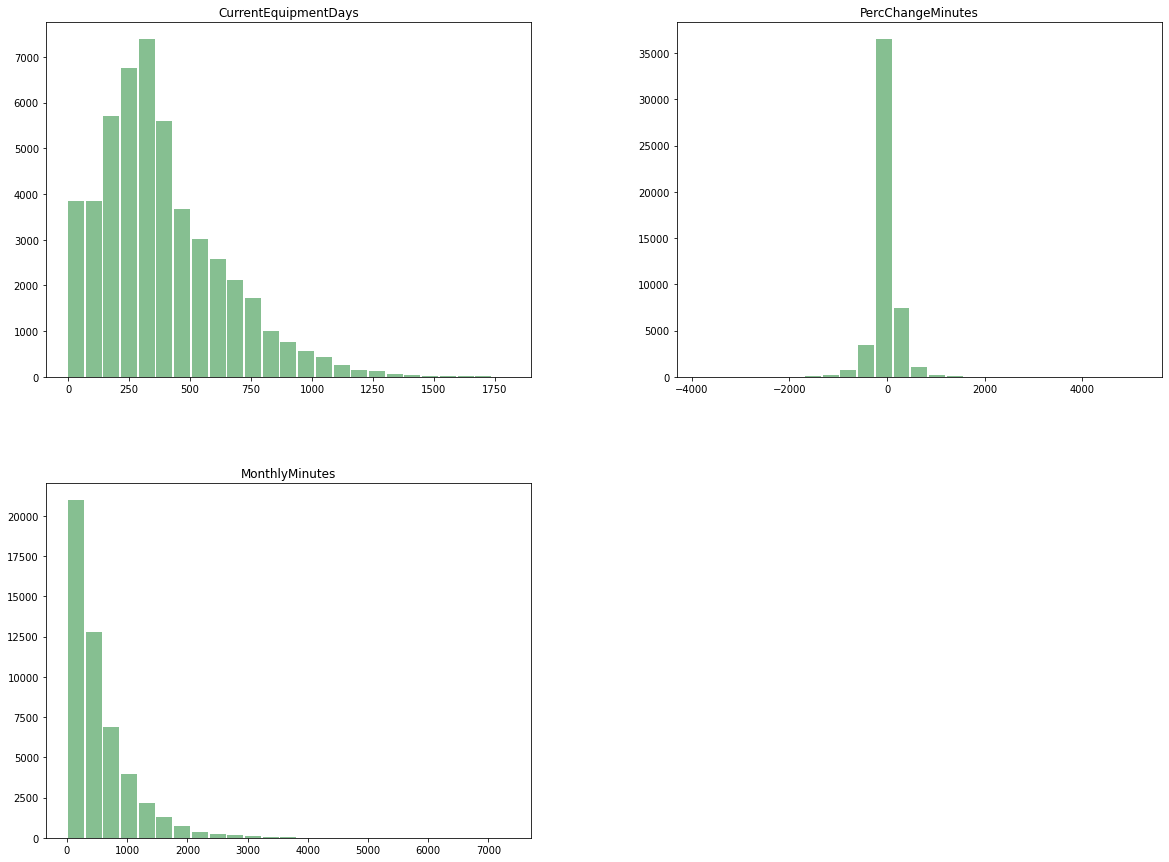

In [ ]:
print(y_df.groupby(['Churn'])['Churn'].value_counts(sort=True))
numcolanalysis(x_df)

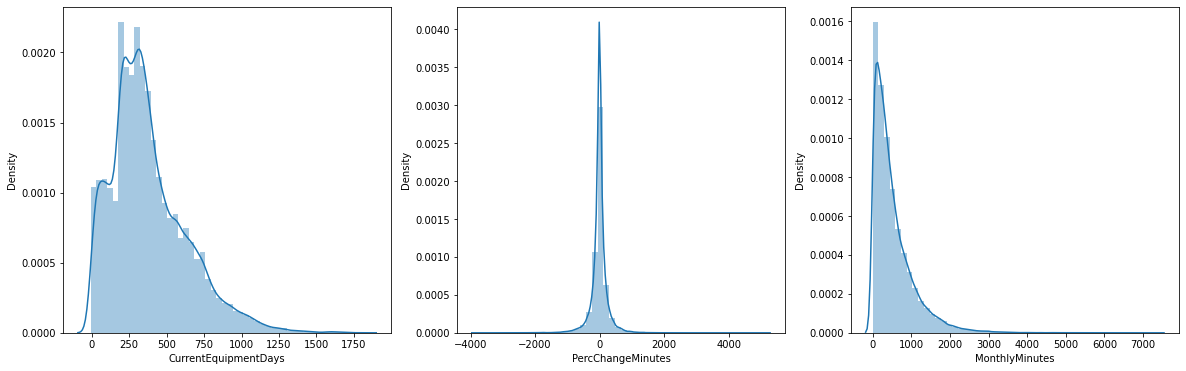

In [ ]:
fig, (ax1, ax2,ax3) = plt.subplots(ncols=3, figsize=(20,6))
s = sns.distplot(ax = ax1,  a=x_df['CurrentEquipmentDays'],bins=50)
s = sns.distplot(ax = ax2, a=x_df['PercChangeMinutes'],bins=50)
s = sns.distplot(ax = ax3, a=x_df['MonthlyMinutes'],bins=50)
# sns.distplot(x_df['CurrentEquipmentDays'])

In [ ]:
list_of_dists = ['alpha','beta','cauchy','chi','cosine','dgamma','dweibull','expon','exponnorm','foldcauchy','foldnorm',
                 'gamma','halfcauchy','halfnorm', 'invgamma','invgauss', 'invweibull','laplace','logistic',
                 'lognorm','norm', 'uniform','wald','weibull_min','weibull_max']

In [ ]:
def show_goodness(list,col):
  results = []
  for i in list:
    dist = getattr(stats, i)
    param = dist.fit(col)
    a = stats.kstest(col, i, args=param)
    results.append((i,a[0],a[1]))
    
  results.sort(key=lambda x:float(x[2]), reverse=True)
  for j in results:
    print("{}: statistic={}, pvalue={}".format(j[0], j[1], j[2]))

In [ ]:
print("\n-----For Current Equipment Days------")
show_goodness(list_of_dists, x_df['CurrentEquipmentDays'])
print("\n-----For Per Change Minutes------")
show_goodness(list_of_dists, x_df['PercChangeMinutes'])
print("\n-----For Monthly Minutes------")
show_goodness(list_of_dists, x_df['MonthlyMinutes'])


-----For Current Equipment Days------
invweibull: statistic=0.02189635360003238, pvalue=3.819850879035137e-21
invgamma: statistic=0.023859375431206503, pvalue=5.018608617640255e-25
exponnorm: statistic=0.02449411532934083, pvalue=2.367351969025964e-26
gamma: statistic=0.04108251732719381, pvalue=2.3202420154853812e-73
beta: statistic=0.05096251560717538, pvalue=1.1654160890693402e-112
chi: statistic=0.06593348149209399, pvalue=2.753766446500067e-188
logistic: statistic=0.06978628726855653, pvalue=6.96986022769389e-211
dgamma: statistic=0.07618347954271419, pvalue=3.091002852366429e-251
dweibull: statistic=0.07888735485262396, pvalue=2.348498412159328e-269
invgauss: statistic=0.08246756052515716, pvalue=2.551180770093444e-294
alpha: statistic=0.9068149459327922, pvalue=0.0
cauchy: statistic=0.12535018011848909, pvalue=0.0
cosine: statistic=0.2779865316436796, pvalue=0.0
expon: statistic=0.19028967877151, pvalue=0.0
foldcauchy: statistic=0.8731719491876582, pvalue=0.0
foldnorm: statisti

## **Sampling**
Below given code is important to run as it contains variables that are used in all sampling methods

In [ ]:
# converting it into simple arrays
y_simple = y_df.values
c = x_df['CurrentEquipmentDays'].values
x_perc_change_min = x_df['PercChangeMinutes'].values
x_monthly_minutes = x_df['MonthlyMinutes'].values

#scaling
x_monthly_minutes=get_scaled_df(x_monthly_minutes,0)
x_perc_change_min=get_scaled_df(x_perc_change_min,0)

### **NUTS Sampling**
* Since we have no prior knowledge about these parameters, we can assume that it could be anything.
* First, I have implemented NUTS Sampling. As we have seen that our "CurrentEquipmentDays" histogram disribution is multimodal therefore, I have used Gaussian mixture model to capture the peaks in the form of clusters.
* Next, I have used Uniform, Normal distribution and Exponential distribution for two remaining predictors, then used Deterministic Distribution over the predictors values. Here, we are applying logistic regrassion and using Bernoulli since we two have classes in target variable.
* Lastly, due to resources contraints, I chose only 100 draws with two steps: Elemwise for Categorical Sampling and NUTS for remaining variables.

**Summary**

* If you check the summary, you will see that there are numerous divergences which is not as it shows that the simulated trajectory is departed from the true trajectory. 
* Since, we have a large dataset and for that number of draws should be atleast greater than 100 in order to cover more data and make plausible estimations  as this process has hardly covered 10% of the entire data however, within time and resources, I could not exceed my draws. 

**Convergence Diagnosis**
* There were 66 divergences.
* Metropolis has efficently covered the samples in all the variables.
* The r_hat score was ~1 which is a good sign.
* From trace plot, we can witness that the chains are almost overlapping to each other completely which means the selection of priors and likelihood were appropriate for the predictors as well as target variable.
* From forest plot wih 94% HDI, we can see few variables are centered while few of them are spread across the mean.
* Lastly, the histograms from sampled variables has shown a valid distribution which is not as same as we saw earlier while performing EDA however, we can say that it gives us the right glimpse of the data distribution.

In [ ]:
lower=10
higher=100
with pm.Model() as nuts_model:
    days_p = pm.Dirichlet("days_p", a=np.array([10, 40, 20]), shape=3)
    # ensure all clusters have some points
    p_min_potential = pm.Potential("p_min_potential", T.tensor.switch(T.tensor.min(days_p) < 0.1, -np.inf, 0))
    centers = pm.Normal("centers", mu=[100, 180, 350], sigma=0.5, shape=3)
    # measurement error
    days_sd = pm.Uniform("days_sd", lower=0, upper=10)
    # latent cluster of each observation
    category = pm.Categorical("category", p=days_p)
    # likelihood for each observed value
    eq_days = pm.Normal("eq_days", mu=centers[category], sigma=days_sd, observed=y_simple)
  

    #priors on parameters
    alpha = pm.Uniform('beta_0', lower=lower, upper= higher)
    # beta = pm.Normal('beta', mu=0, sd=10, shape=2)
    beta_p_change_min = pm.Normal('beta_p_change_min',  mu=0, sigma=2)
    beta_monthly_min = pm.Exponential('beta_monthly_min', lam=0.5)
    
    #the probability of belonging to class 1
    p = pm.Deterministic('p', pm.math.sigmoid(alpha +  beta_p_change_min*x_perc_change_min +
                               beta_monthly_min*x_monthly_minutes))
    # p = alpha + beta[0]*x_perc_change_min + beta[1]*x_monthly_minutes
    obs_month_min=pm.Bernoulli("obs_month_min", p, observed=y_simple)
    
    #Sampling ------ NUTS
    step1 = pm.NUTS(vars=[alpha, beta_p_change_min, beta_monthly_min, p, obs_month_min, days_sd, centers, days_p])
    step2 = pm.CategoricalGibbsMetropolis(vars=[category]) 
    sample_nuts = pm.sample(draws=100, step=[step1, step2])

az.summary(sample_nuts)
# # az.plot_trace(sample_nuts, var_names=["p", "sd", "means", "category", "amount_mu", "sigma_x", "beta_x", "alpha_x" ]);

Only 100 samples in chain.
Sequential sampling (2 chains in 1 job)
CompoundStep
>NUTS: [days_p, centers, days_sd, beta_0, beta_p_change_min, beta_monthly_min]
>CategoricalGibbsMetropolis: [category]


Sampling 2 chains for 1_000 tune and 100 draw iterations (2_000 + 200 draws total) took 1475 seconds.
There were 24 divergences after tuning. Increase `target_accept` or reparameterize.
There were 42 divergences after tuning. Increase `target_accept` or reparameterize.
Got error No model on context stack. trying to find log_likelihood in translation.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
centers[0],0.288,0.002,0.284,0.291,0.000,0.000,175.0,100.0,0.99
centers[1],180.020,0.567,178.988,181.009,0.040,0.028,195.0,156.0,1.05
centers[2],349.974,0.483,349.094,350.774,0.035,0.025,180.0,162.0,0.99
category,0.000,0.000,0.000,0.000,0.000,0.000,200.0,200.0,NaN
beta_p_change_min,0.608,0.023,0.556,0.639,0.002,0.001,160.0,136.0,1.00
...,...,...,...,...,...,...,...,...,...
"p[49747, 0]",1.000,0.000,1.000,1.000,0.000,0.000,158.0,136.0,1.00
"p[49748, 0]",1.000,0.000,1.000,1.000,0.000,0.000,159.0,136.0,1.00
"p[49749, 0]",1.000,0.000,1.000,1.000,0.000,0.000,160.0,136.0,1.00
"p[49750, 0]",1.000,0.000,1.000,1.000,0.000,0.000,162.0,136.0,1.00


Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.


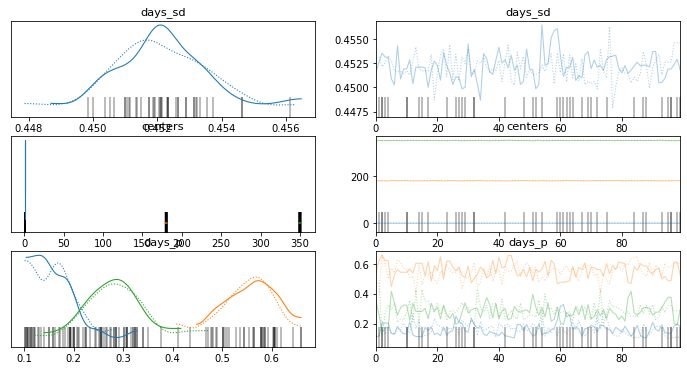

In [ ]:
az.plot_trace(sample_nuts, var_names=['days_sd', 'centers', 'days_p']);

Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.


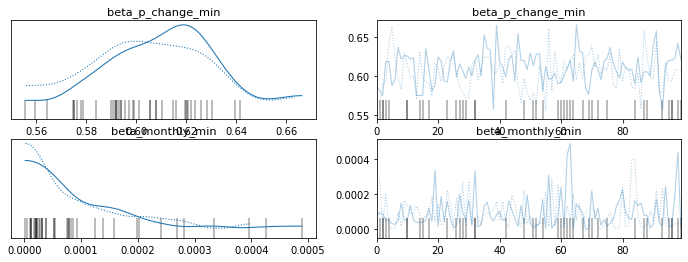

In [ ]:
az.plot_trace(sample_nuts, var_names=['beta_p_change_min', 'beta_monthly_min']);

Got error No model on context stack. trying to find log_likelihood in translation.


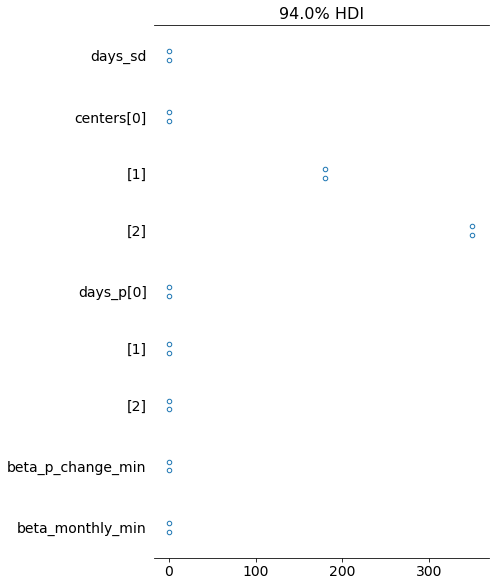

In [ ]:
az.plot_forest(sample_nuts, var_names=['days_sd', 'centers', 'days_p','beta_p_change_min', 'beta_monthly_min']);

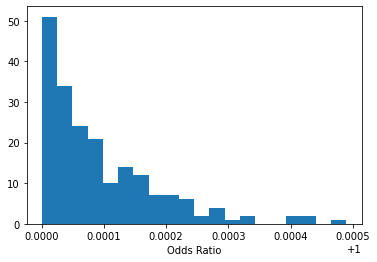

In [ ]:
b = sample_nuts['beta_monthly_min']
plt.hist(np.exp(b), bins=20)
plt.xlabel("Odds Ratio")
plt.show();

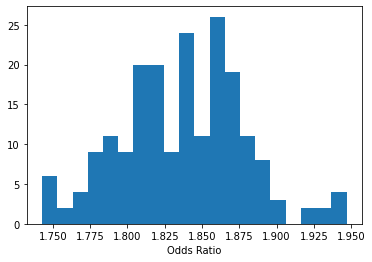

In [ ]:
b = sample_nuts['beta_p_change_min']
plt.hist(np.exp(b), bins=20)
plt.xlabel("Odds Ratio")
plt.show();

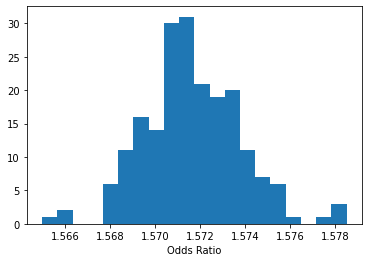

In [ ]:
b = sample_nuts['days_sd']
plt.hist(np.exp(b), bins=20)
plt.xlabel("Odds Ratio")
plt.show();

## **NUTS Sampling using GLM**

Here, I have used Generalized Linear Model, there are 3 components to any GLM: 
- Random Component – refers to the probability distribution of the response variable (Y); e.g. normal distribution for Y in the linear regression, or binomial distribution for Y in the binary logistic regression. 
- Systematic Component - specifies the explanatory variables  in the model, more specifically their linear combination in creating the so called linear predictor.
Link Function,  or  - specifies the link between random and systematic components. It says how the expected value of the response relates to the linear predictor of explanatory variables.
* Here, I didn't choose the link function manually. With 1000 draws, GLM has given very good results. 

**Convergence Diagnosis**

* If you check the summary, you will see that there are no divergences which is good. Then, r_hat score is ~ 1. 
* To diagnose convergence, I have used trace plots. We can say that posterior mean is closer to zero. Overlapping can be witnessed a few intervals which means that model worked but not given 100% results.
* Infact, if I would have increased number of draws as we have a large dataset and 1000 is very small part of it then each of the predictor could have covered more data and given better results.
* Further, the confusion metric has shown relatively good results, with a very small percentage of "True Positives" which is not true because the difference between 0 and 1 labels in target class is not that much.
* Lastly, the right ppc plot has shown negligible bar of class-1 which is incorrect as we can compare the true value from left plot.

In [ ]:
with pm.Model() as logistic_model:
    pm.glm.GLM.from_formula('y_simple ~ x_equipment_days + x_perc_change_min + x_monthly_minutes', x_df, family = pm.glm.families.NegativeBinomial())
    trace = pm.sample(100, tune = 1000, init = 'adapt_diag')
az.summary(trace)

The glm module is deprecated and will be removed in version 4.0
We recommend to instead use Bambi https://bambinos.github.io/bambi/
WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [alpha, mu, x_monthly_minutes, x_perc_change_min, x_equipment_days, Intercept]


Sampling 2 chains for 1_000 tune and 100 draw iterations (2_000 + 200 draws total) took 980 seconds.
Got error No model on context stack. trying to find log_likelihood in translation.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,-1.462,0.018,-1.491,-1.428,0.002,0.001,138.0,140.0,1.02
x_equipment_days,0.001,0.000,0.000,0.001,0.000,0.000,126.0,85.0,1.00
x_perc_change_min,-0.035,0.005,-0.044,-0.024,0.000,0.000,240.0,181.0,1.01
x_monthly_minutes,-0.046,0.011,-0.069,-0.028,0.001,0.001,163.0,157.0,1.00
mu,47.142,184.207,0.157,89.921,14.762,10.458,197.0,115.0,1.00
alpha,42132.760,347130.191,304.951,43727.371,29383.655,20820.958,212.0,108.0,0.99


Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f8488ad5390>,
      dtype=object)

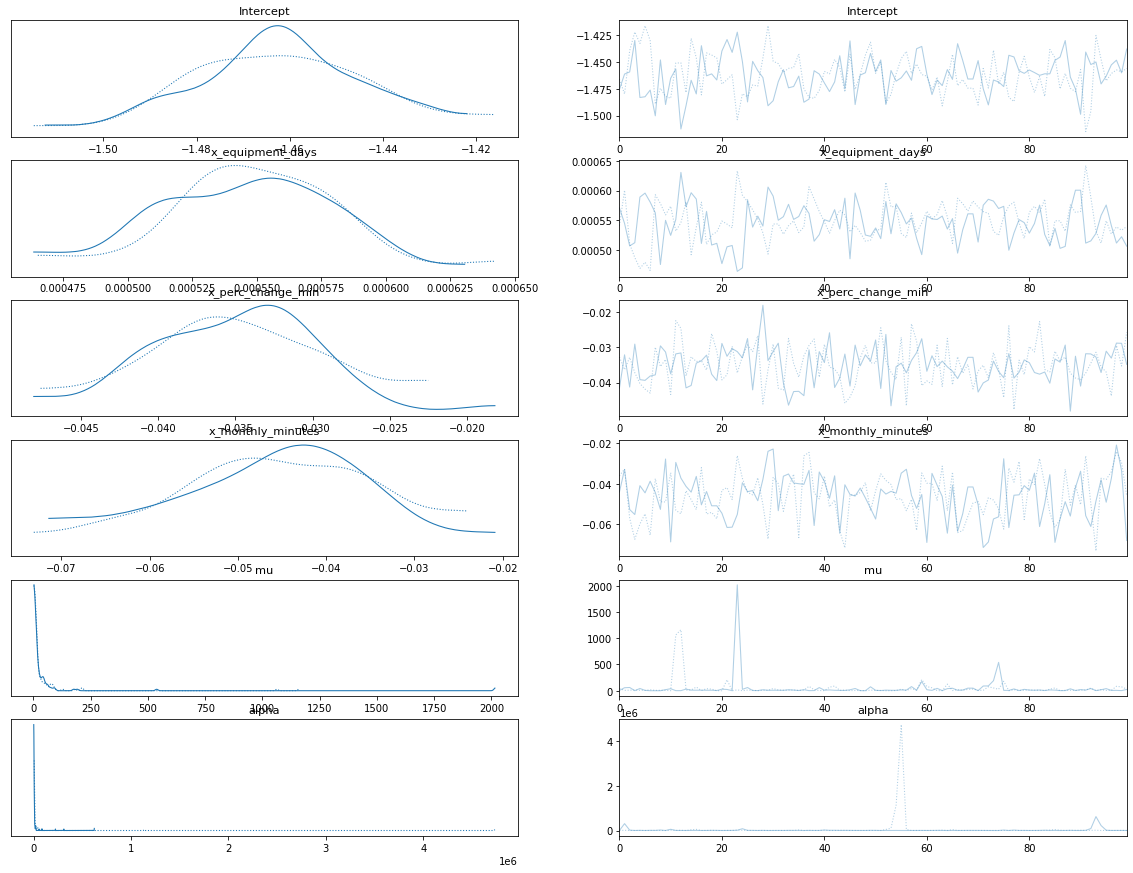

In [ ]:
az.plot_trace(trace, figsize=(20,15))

In [ ]:
az.summary(trace)

Got error No model on context stack. trying to find log_likelihood in translation.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,-1.462,0.018,-1.491,-1.428,0.002,0.001,138.0,140.0,1.02
x_equipment_days,0.001,0.000,0.000,0.001,0.000,0.000,126.0,85.0,1.00
x_perc_change_min,-0.035,0.005,-0.044,-0.024,0.000,0.000,240.0,181.0,1.01
x_monthly_minutes,-0.046,0.011,-0.069,-0.028,0.001,0.001,163.0,157.0,1.00
mu,47.142,184.207,0.157,89.921,14.762,10.458,197.0,115.0,1.00
alpha,42132.760,347130.191,304.951,43727.371,29383.655,20820.958,212.0,108.0,0.99


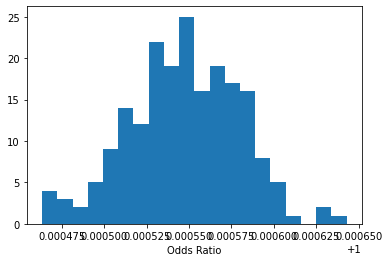

In [ ]:
b = trace['x_equipment_days']
plt.hist(np.exp(b), bins=20)
plt.xlabel("Odds Ratio")
plt.show();

Confusion matrix
[[35414    93]
 [14188    57]]


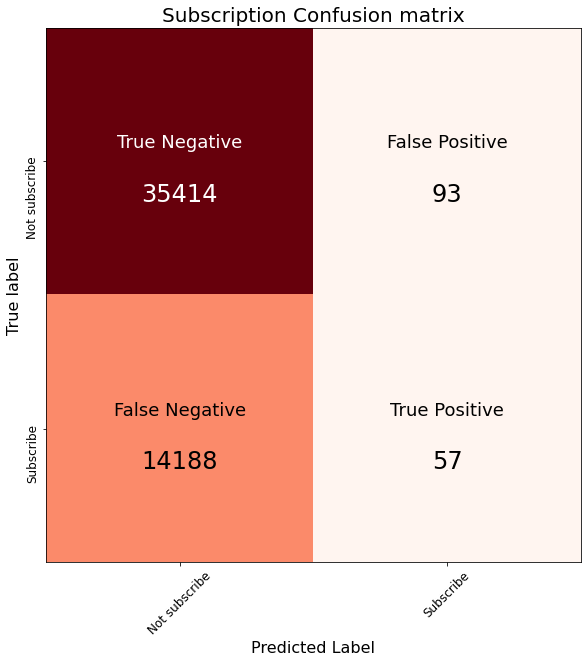

In [ ]:
ppc = pm.sample_posterior_predictive(trace, model=logistic_model, samples=500)
preds = np.rint(ppc['y'].mean(axis=0)).astype('int')

def plot_confusion_matrix(cm, classes = ['Not subscribe', 'Subscribe'],
                          title='Subscription Confusion matrix',
                          cmap=plt.cm.Reds):
    
    # Display the matrix in text form
    print('Confusion matrix')
    print(cm)
    plt.figure(figsize = (8,10))
    # Show the matrix using the imshow functionality
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size = 20)
    
    # Tick marks show classes
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, size = 12)
    plt.yticks(tick_marks, classes, rotation = 90, size = 12)

    # Formatting for text labels on plot
    fmt1 = 's'
    fmt2 = 'd'
    thresh = cm.max() / 2.
    
    # Four types of classifications
    types = [['True Negative', 'False Positive'],
             ['False Negative', 'True Positive']]
    
    # Add the actual numbers and the types onto the heatmap plot
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i - 0.05, format(types[i][j], fmt1),
                 horizontalalignment="center", size = 18,
                 color="white" if cm[i, j] > thresh else "black")
        
        plt.text(j, i + 0.15, format(cm[i, j], fmt2),
                 horizontalalignment="center", size = 24,
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    
    plt.ylabel('True label', size = 16)
    plt.xlabel('Predicted Label', size = 16)
    
cm = confusion_matrix(y_simple, preds)
plot_confusion_matrix(cm)

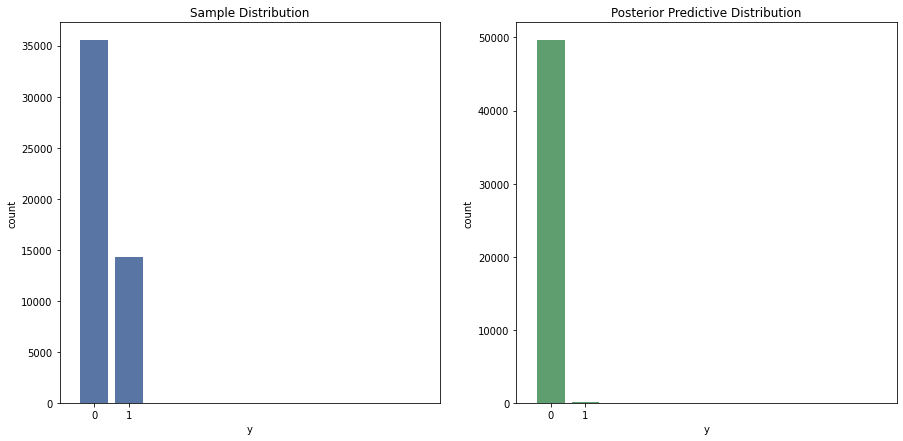

In [ ]:
with logistic_model:
  fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 7))
  sns.countplot(x=y_df['Churn'], color=sns_c[0], ax=ax[0])
  ax[0].set(title='Sample Distribution', xlabel='y', xlim=(-1, 10))
  sns.countplot(x=preds, color=sns_c[2], ax=ax[1])
  ax[1].set(title='Posterior Predictive Distribution', xlabel='y', xlim=(-1, 10));

## **Metropolis Hasting Sampling**

**Convergence Diagnosis**
* Here, I have implemented same model I used for NUTS sampling, but unfortunately, I have got worse results.
* Again due to time constraints I selected only 100 draws.
The model didn't converge while no divergence as well. 
* The rhat statistic is larger than 1.4 for some parameters.
* The number of effective samples is smaller than 10% for some parameters.
* If I would have increased number of draws as we have a large dataset and 100 is extremely a small part of it then each of the predictor could have covered more data and given better results.
* Trace plot has shown that model couldn't find its way at all.
* Forest plot has shown that clusters for "CurrentEquipmentDays" column is deviating from mean and going in another direction.

In [ ]:
with pm.Model() as mh_model:
    days_p = pm.Dirichlet("days_p", a=np.array([10, 40, 20]), shape=3)
    # ensure all clusters have some points
    p_min_potential = pm.Potential("p_min_potential", T.tensor.switch(T.tensor.min(days_p) < 0.1, -np.inf, 0))
    centers = pm.Normal("centers", mu=[100, 180, 350], sigma=0.5, shape=3)
    # measurement error
    days_sd = pm.Uniform("days_sd", lower=0, upper=10)
    # latent cluster of each observation
    category = pm.Categorical("category", p=days_p)
    # likelihood for each observed value
    eq_days = pm.Normal("eq_days", mu=centers[category], sigma=days_sd, observed=y_simple)
  

    #priors on parameters
    alpha = pm.Uniform('beta_0', lower=10, upper= 100)
    # beta = pm.Normal('beta', mu=0, sd=10, shape=2)
    beta_p_change_min = pm.Normal('beta_p_change_min',  mu=0, sigma=2)
    beta_monthly_min = pm.Exponential('beta_monthly_min', lam=0.5)
    
    #the probability of belonging to class 1
    p = pm.Deterministic('p', pm.math.sigmoid(alpha +  beta_p_change_min*x_perc_change_min +
                               beta_monthly_min*x_monthly_minutes))
    # p = alpha + beta[0]*x_perc_change_min + beta[1]*x_monthly_minutes
    obs_month_min=pm.Bernoulli("obs_month_min", p, observed=y_simple)
    
    #Sampling ------ Metropolis
    step1 = pm.Metropolis(vars=[alpha, beta_p_change_min, beta_monthly_min, p, obs_month_min, days_sd, centers, days_p])
    step2 = pm.CategoricalGibbsMetropolis(vars=[category]) 
    sample_mh = pm.sample(draws=100, step=[step1, step2])

az.summary(sample_mh)

Only 100 samples in chain.
Sequential sampling (2 chains in 1 job)
CompoundStep
>CompoundStep
>>Metropolis: [days_p]
>>Metropolis: [centers]
>>Metropolis: [days_sd]
>>Metropolis: [beta_0]
>>Metropolis: [beta_p_change_min]
>>Metropolis: [beta_monthly_min]
>CategoricalGibbsMetropolis: [category]


Sampling 2 chains for 1_000 tune and 100 draw iterations (2_000 + 200 draws total) took 199 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The number of effective samples is smaller than 10% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
centers[0],0.287,0.002,0.281,0.291,0.001,0.000,17.0,6.0,2.54
centers[1],160.621,3.257,157.302,163.869,2.209,1.839,2.0,6.0,2.99
centers[2],356.303,2.200,354.109,358.533,1.492,1.242,3.0,2.0,2.33
category,0.000,0.000,0.000,0.000,0.000,0.000,200.0,200.0,NaN
beta_p_change_min,0.610,0.018,0.583,0.634,0.004,0.003,18.0,14.0,1.49
...,...,...,...,...,...,...,...,...,...
"p[49747, 0]",1.000,0.000,1.000,1.000,0.000,0.000,21.0,14.0,1.36
"p[49748, 0]",1.000,0.000,1.000,1.000,0.000,0.000,18.0,14.0,1.41
"p[49749, 0]",1.000,0.000,1.000,1.000,0.000,0.000,19.0,14.0,1.43
"p[49750, 0]",1.000,0.000,1.000,1.000,0.000,0.000,19.0,14.0,1.41


Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.


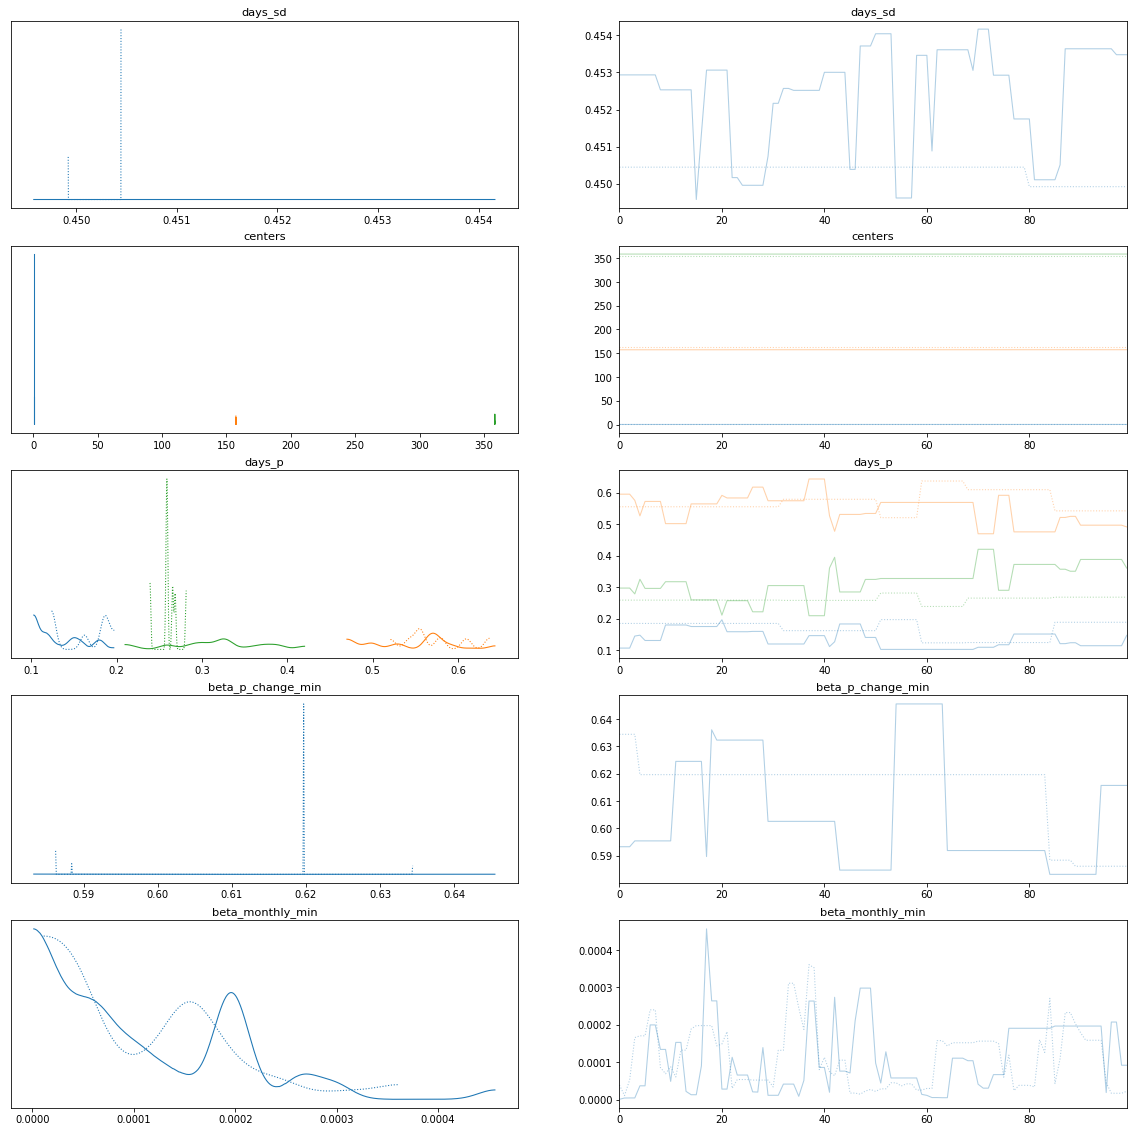

In [ ]:
az.plot_trace(sample_mh,  var_names=['days_sd', 'centers', 'days_p','beta_p_change_min', 'beta_monthly_min'],figsize=(20,20));

Got error No model on context stack. trying to find log_likelihood in translation.


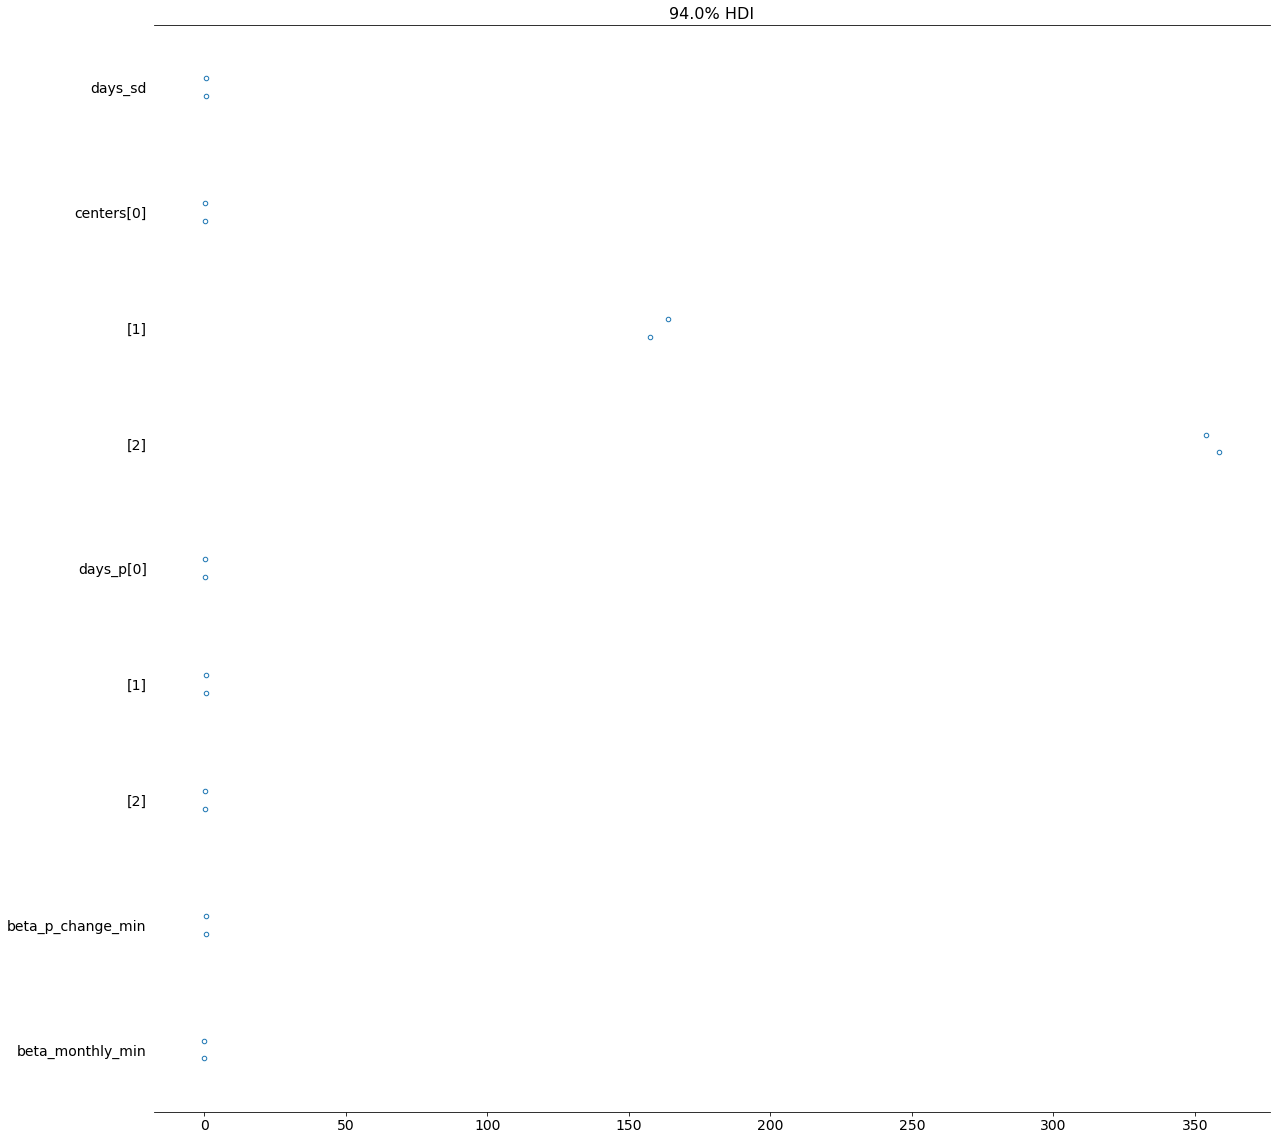

In [ ]:
az.plot_forest(sample_mh,  var_names=['days_sd', 'centers', 'days_p','beta_p_change_min', 'beta_monthly_min'],figsize=(20,20));

In [ ]:
# with mh_model:
#   ppc = pm.sample_posterior_predictive(sample_mh, model=mh_model, samples=500)
  
preds = np.rint(ppc['obs_month_min'].mean(axis=0)).astype('int')
bins = np.linspace(min(preds), max(preds), 50)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 7))
sns.countplot(x=x_df['MonthlyMinutes'].values, color=sns_c[0], ax=ax[0])
ax[0].set(title='Sample Distribution for MonthlyMinutes', xlabel='y', xlim=(-1, 10))
sns.countplot(x=bins, color=sns_c[2], ax=ax[1])
ax[1].set(title='Posterior Predictive Distribution for MonthlyMinutes', xlabel='y', xlim=(-1, 10));

## **Hamiltonian MC Sampling**
**Convergence Diagnosis**

* Here, I have implemented the same model I used for NUTS for "CurrenEquipmentDays" feature and basic normal and half normal distribution for other two fetaures. 
* Again due to time constraints I selected only 100 draws.
* The acceptance probability is greater than target. For which, it is my assumpion that if I could have increased number of draws, I would have achieved better accuracy.
* The r-hat score in all variables is ~1.
* All density and forest plot have shown good results. 
* The mean is closer to 0 but negative in some parameters.

In [ ]:
with pm.Model() as hmc_model:
  
  #CurrentEquipmentDays
  # define priors
  days_mu = pm.Uniform('days_mu', lower=0, upper=100)
  days_sigma = pm.Uniform('days_sigma', lower=10, upper=100)
  # define likelihood
  days = pm.Normal("x_equipment_days", mu=days_mu, sd=days_sigma, observed=y_simple)

  # Priors for unknown model parameters
  alpha = pm.Normal('alpha', mu=0, sd=5)
  beta = pm.Normal('beta', mu=0, sd=5, shape=2)
  sigma = pm.HalfNormal('sigma', sd=4)

  # Expected value of outcome
  mu = alpha + beta[0] * x_perc_change_min + beta[1] * x_monthly_minutes
    
  # Likelihood (sampling distribution) of observations
  obs_month_min = pm.Normal('obs_month_min', mu=mu, sd=sigma, observed=y_simple) 

  #Sampling ------ HamiltonianMC
  step1 = pm.HamiltonianMC(vars=[ beta, sigma, days_sigma, days_mu])
  sample_hmc = pm.sample(draws=100, tune=100, step=[step1])

az.summary(sample_hmc)

Only 100 samples in chain.
Sequential sampling (2 chains in 1 job)
CompoundStep
>HamiltonianMC: [days_mu, days_sigma, sigma, beta]
>NUTS: [alpha]


Sampling 2 chains for 100 tune and 100 draw iterations (200 + 200 draws total) took 553 seconds.
The acceptance probability does not match the target. It is 0.9027263153565015, but should be close to 0.65. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9401213223003486, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8740906153100645, but should be close to 0.65. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.923799169659719, but should be close to 0.8. Try to increase the number of tuning steps.
Got error No model on context stack. trying to find log_likelihood in translation.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.293,0.002,0.290,0.297,0.000,0.000,60.0,132.0,1.04
beta[0],-0.009,0.001,-0.012,-0.007,0.000,0.000,169.0,107.0,1.00
beta[1],-0.025,0.002,-0.030,-0.021,0.000,0.000,109.0,72.0,1.01
days_mu,0.293,0.045,0.221,0.364,0.003,0.002,184.0,120.0,1.03
days_sigma,10.000,0.000,10.000,10.001,0.000,0.000,122.0,73.0,1.01
sigma,0.451,0.001,0.448,0.454,0.000,0.000,221.0,100.0,1.00


Got error No model on context stack. trying to find log_likelihood in translation.


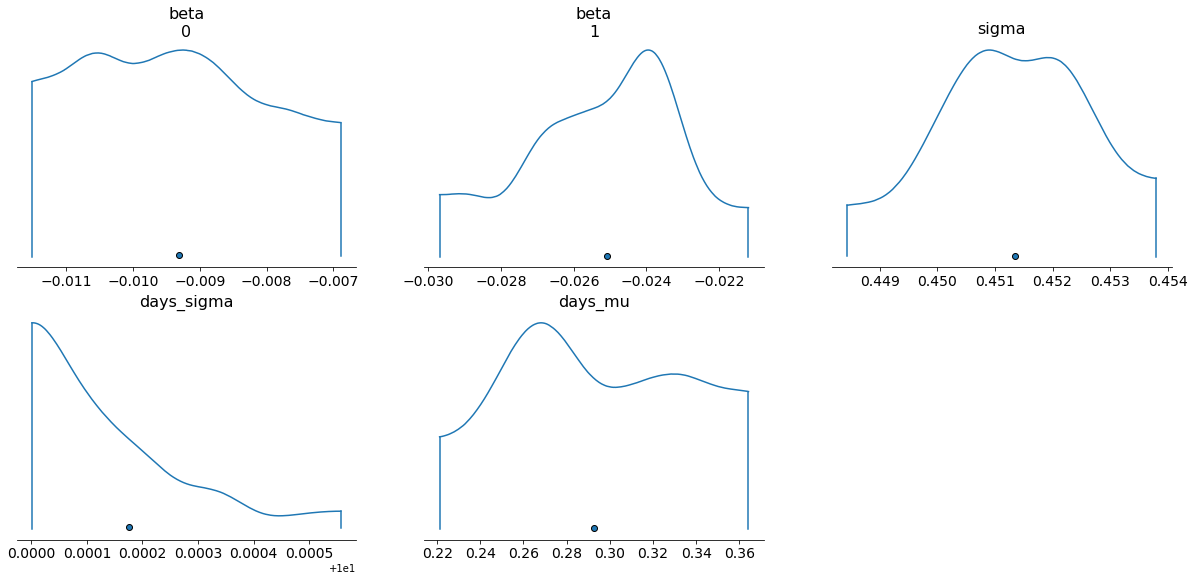

In [ ]:
az.plot_density(sample_hmc, var_names=['beta', 'sigma', 'days_sigma', 'days_mu']);

Got error No model on context stack. trying to find log_likelihood in translation.


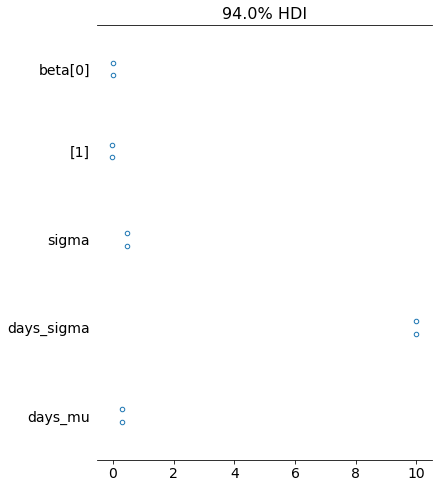

In [ ]:
az.plot_forest(sample_hmc,  var_names=['beta', 'sigma',  'days_sigma', 'days_mu']);

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f81a51f4fd0>,
      dtype=object)

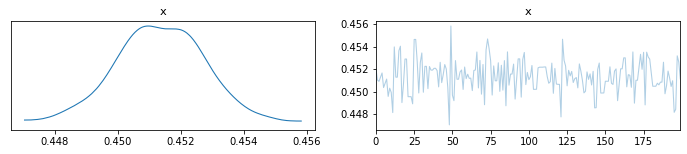

In [ ]:
az.plot_trace(sample_hmc['sigma'])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f81a58abe50>,
      dtype=object)

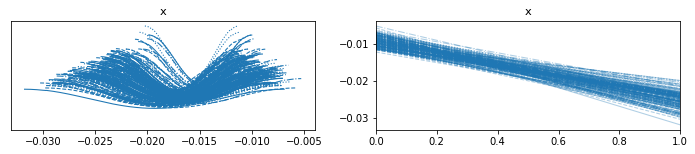

In [ ]:
az.plot_trace(sample_hmc['beta'])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f81a7ea1a10>,
      dtype=object)

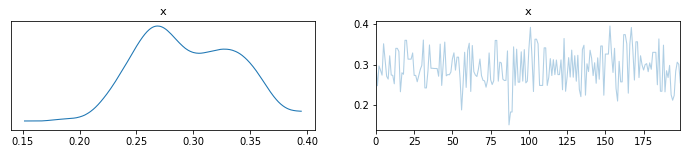

In [ ]:
az.plot_trace(sample_hmc['days_mu'])